Practical 1: The goal of this practical session is to build backprop from scratch and a small neural network (MLP).

Please return your notebook right at the end of the session.  You then have a week to return an updated version.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from graphviz import Digraph

In [4]:
# code to display a network - do not modify this cell
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    layer_colors = ["#FFCCCC", "#CCFFCC", "#CCCCFF", "#FFCC99", "#99CCFF"]
    
    def get_color(node):
        if node._op == '+': return layer_colors[0]
        elif node._op == '*': return layer_colors[1]
        elif node._op == 'tanh': return layer_colors[2]
        # Ajoutez d'autres conditions ici pour d'autres opérations ou couches
        return layer_colors[-1]  # Couleur par défaut
    
    for n in nodes:
        color = get_color(n)
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record', style='filled', fillcolor=color)
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [5]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data+other.data,_children=(self,other), _op='+')
    def _backward(): 
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data*other.data, _children=(self,other), _op='*')
    def _backward(): 
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __pow__(self, other): # ex. 6
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward(): 
      self.grad += (other * self.data**(other-1))*out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other): # other * self
    return self * other 

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self): # TODO ex.3
    t = (math.exp(2*self.data)-1)/(math.exp(2*self.data)+1)
    out = Value(t, (self,), _op='tanh')
    def _backward(): 
      self.grad += (1-t**2)* out.grad
    out._backward = _backward
    return out
    
  def exp(self): # ex.6
    out = Value(math.exp(self.data),(self,), 'exp')
    def _backward(): 
      self.grad += math.exp(self.data)*out.grad
    out._backward = _backward
    return out
    
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [6]:
# Exercise 1: fill in __add__ and __mul__ in the Value class to enable the following function. You should get -8.0 as a result.
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    return L

print(lol().data)

-8.0


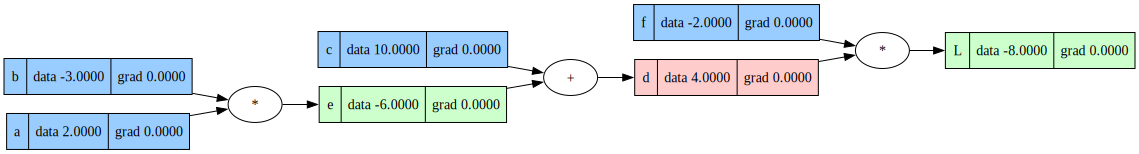

In [7]:
draw_dot(lol())

In [8]:
# Exercise 2: use the lol_grad() function below to manually compute dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

In [9]:
# dL/df = 4.0
def lol_grad():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    f += h
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
lol_grad()

3.9999999999995595


In [10]:
# dL/dd = -2
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
lol_grad()

-1.9999999999953388


In [11]:
#dL/de = -2
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    e += h
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
lol_grad()

-1.9999999999953388


In [12]:
#dL/dc = -2
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
lol_grad()

-1.9999999999953388


In [13]:
#dL/da = 6
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    a += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
lol_grad()

6.000000000021544


In [14]:
#dL/db = -4
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b += h
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)
lol_grad()

-4.000000000008441


In [68]:
# report the values for dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db in this cell
# dL/df = 4.0
# dL/dd = -2
#dL/de = -2
#dL/dc = -2
#dL/da = 6
#dL/db = -4


In [15]:
# Exercise 3: implement the function tanh() in the Value class and build the following network
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1z2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



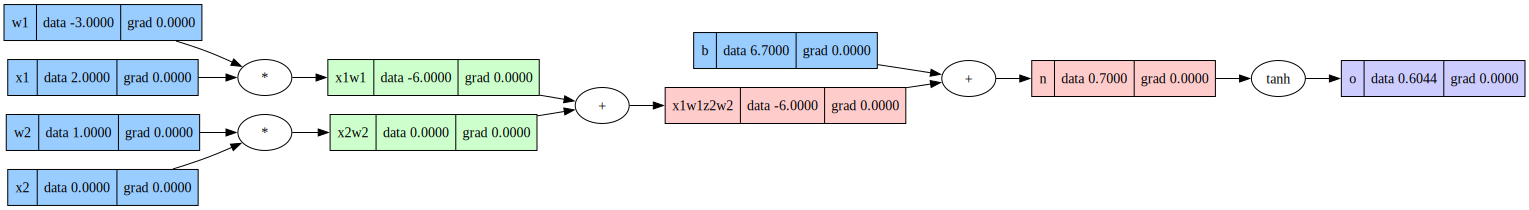

In [16]:
# o.data should be 0.6044
draw_dot(o)

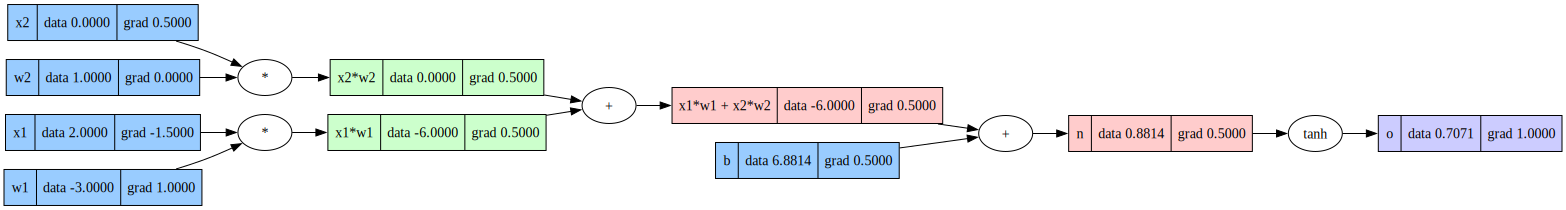

In [17]:
# Exercise 4: Implement the backward() function in each Value's operator: __add__, __mul__, __tanh__ and assign it to _backward
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
o = n.tanh()
# ----
o.label = 'o'
o.backward()
draw_dot(o)

 # expected results:
 # o.data should be 0.7071
 # w1.grad = 1.0
 # w2.grad = 0.0
 # x1.grad = -1.5
 # x2.grad = 0.5

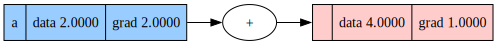

In [76]:
# Exercise 5: why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. 
# Hint: create a Value "a" and then b = a + a. What happens when you do b.backward()?
# If we used "self.grad = ..." it would overwrite the gradient from one path with the 
# gradient from the other path. Instead, by using "self.grad += ..." we ensure that
# the gradients from all paths are summed, correctly applying the chain rule for 
# backpropagation.
a = Value(2.0, label='a')
b = a+a
b.backward()
draw_dot(b)
# For example, if you create a Value "a" and then compute b = a + a, the value "a"
# is used twice in the computation of b. When calling b.backward(), the gradient 
# with respect to "a" will be accumulated from both uses. see the cell below for the "self.grad = ..."

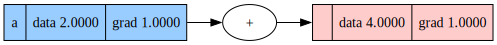

In [74]:
#Please do not rerun this cell, it was obtain by slightly modifying backward fct with "self.grad = ..." 
a = Value(2.0, label='a') 
b = a+a
b.backward()## with "self.grad = ..."
draw_dot(b) 
# When calling b.backward(), the gradient with respect to "a" will NOT be accumulated from both uses.

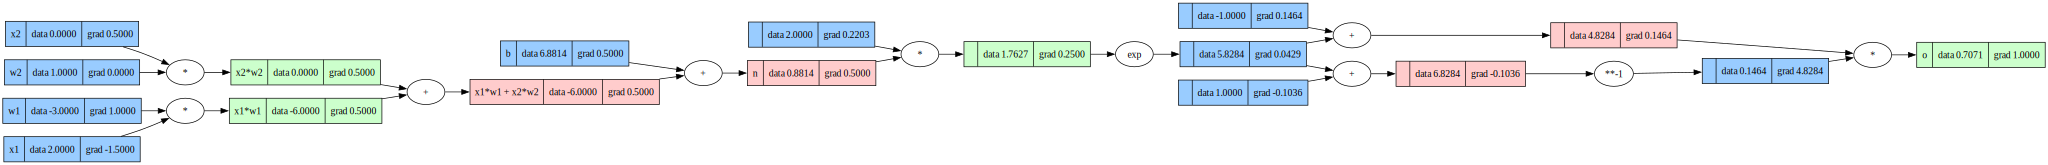

In [18]:
# Exercise 6: replace the tanh() function by a combination of exp() and division.  Implement the __exp__ and __pow__ functions in Value. You should get the same results as before.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = ... (no tanh allowed)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [19]:
# Congratulations!  You "unlocked" the basic layer of pytorch.  Now you know what happens under the hood of the following code. Check that you get the same output as before for grad values.

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [ ]:
# Exercise 7: Let's build an MLP based on the Value class.  Fill in the Neuron, Layer and MLP classes.

In [21]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum(w * x_i for w, x_i in zip(self.w, x))+ self.b
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    params = []
    for neuron in self.neurons:
      params.extend(neuron.parameters())
    return params

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    params = []
    for layer in self.layers:
      params.extend(layer.parameters())
    return params

In [23]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9307701839310155)

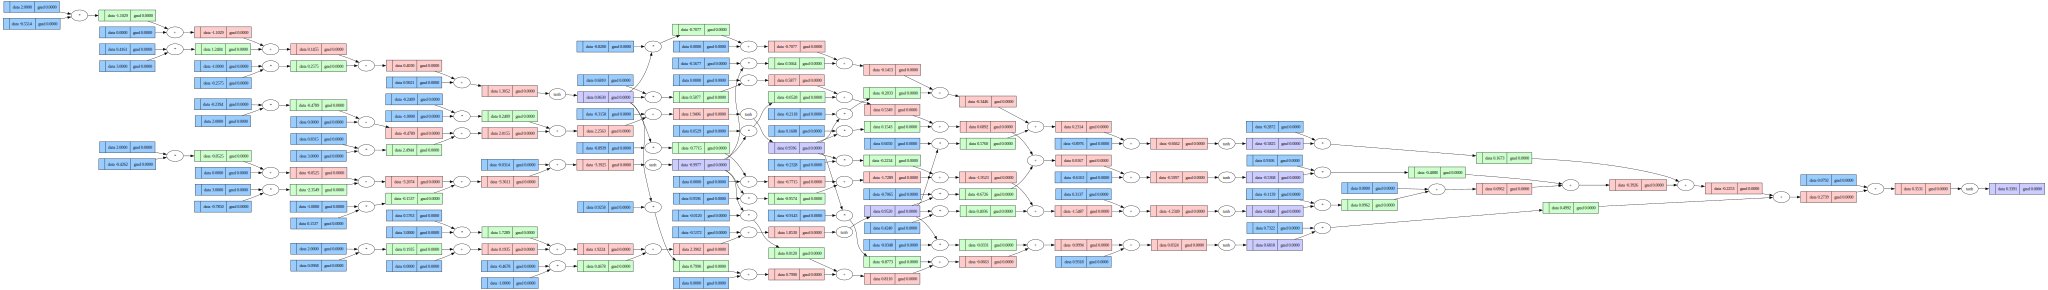

In [51]:
draw_dot(n(x))

In [24]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [25]:
len(n.parameters())

41

In [26]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9307701839310155),
 Value(data=-0.9320319464716261),
 Value(data=-0.9059356917594544),
 Value(data=-0.9204339536854914)]

In [27]:
loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)])
loss

Value(data=7.429407824010305)

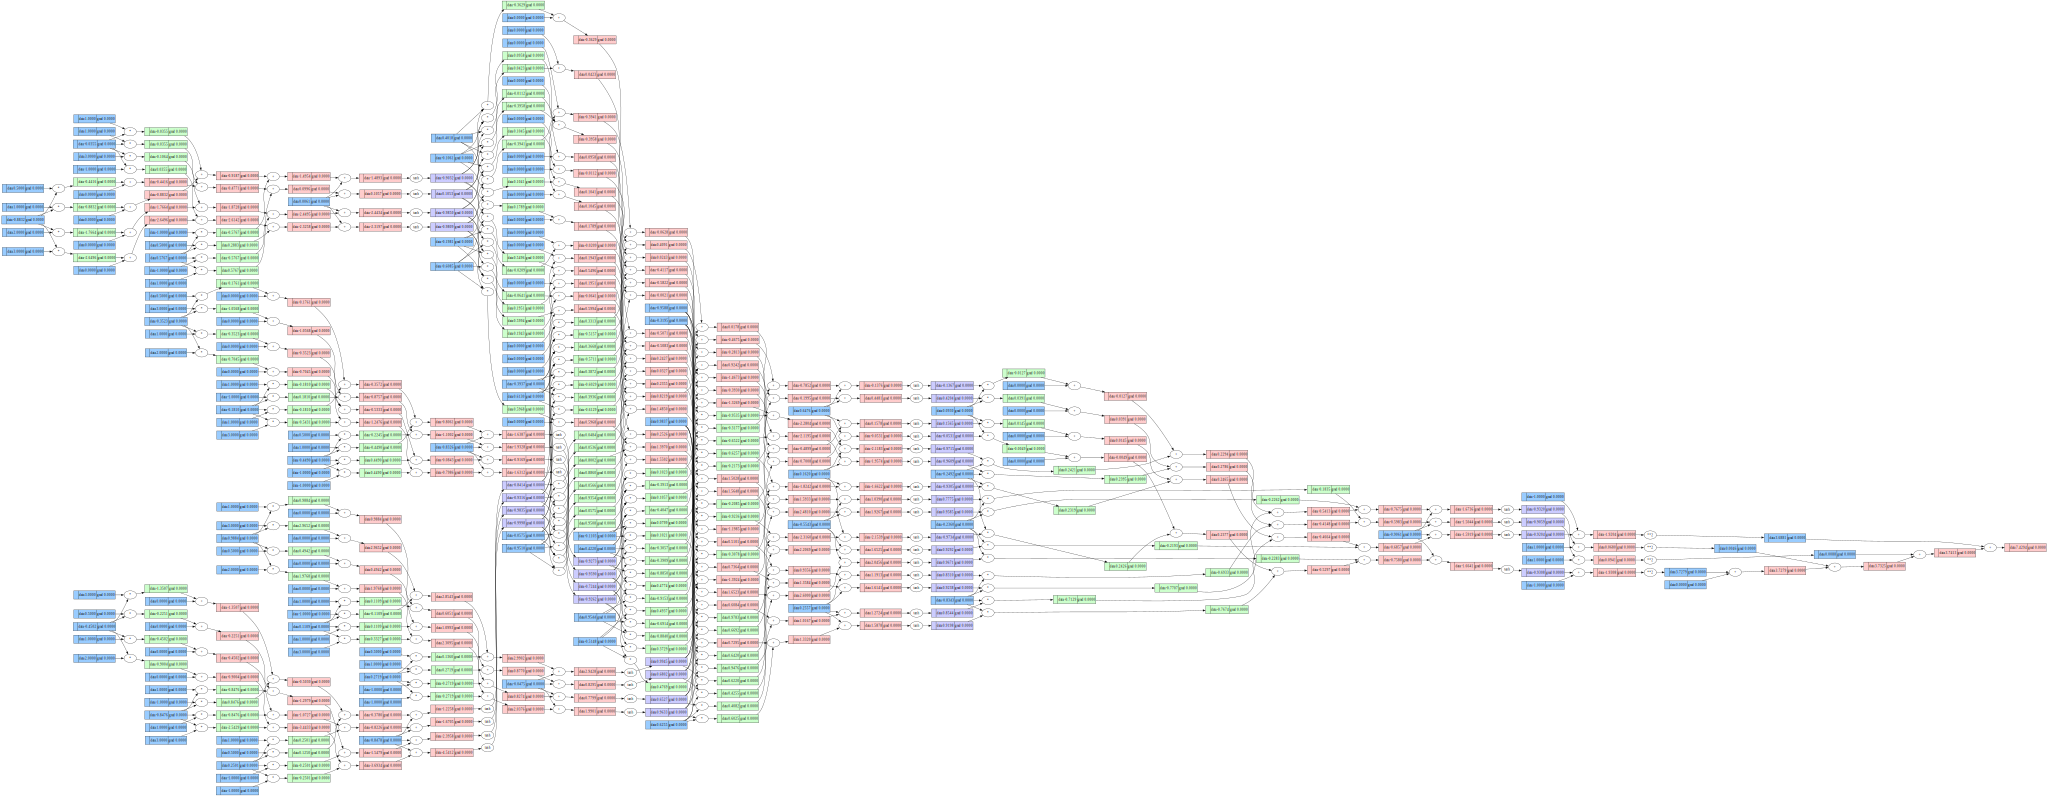

In [28]:
# see how a simple MLP can yield a complex graph already
draw_dot(loss)

In [29]:
# Exercise 8: write a training loop
lr = 0.01
for k in range(20):
    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)]) # MSE between ypred and ground-truth
    #backward pass 
    loss.backward()
    # update
    for p in n.parameters():
        p.data -= lr * p.grad
        p.grad = 0.0
    print(k, loss.data)

0 7.429407824010305
1 7.386064891244496
2 7.336481009289411
3 7.279363484332332
4 7.213083627753964
5 7.135580561206297
6 7.044242500753393
7 6.93577029605941
8 6.806044996398125
9 6.650060844027843
10 6.462068787633044
11 6.236230659279689
12 5.968305599319642
13 5.658997715934497
14 5.318935529440475
15 4.972747401535733
16 4.6560860674696904
17 4.401460626556334
18 4.2217913391089095
19 4.107924171759292


In [ ]:
# Exercise 9: why do you need to reset the grads to zero at every training step?  Answer as a comment in this cell.
#Resetting the gradients to zero at each training step ensures that each update is based solely on 
#the gradients computed from the current batch, avoiding unintended accumulation from previous iterations.

0 138.55426599028613
1 46.789025462922304
2 40.60645065753526
3 19.60665039076111
4 44.369335036237324
5 51.58593750687713
6 51.37108877760459
7 51.07320576660928
8 50.63721154173687
9 49.95030701194604
10 48.74901401778764
11 46.29737279929184
12 40.019360063928325
13 21.28044387785773
14 25.691893034568864
15 43.4538152997346
16 32.6758914212844
17 10.039597284206419
18 10.979536414091912
19 16.005364158713977
20 22.157819082768633
21 39.08184482367863
22 21.513308374092123
23 14.771538136829442
24 23.86576961244671
25 11.561814488663245
26 15.34691647791571
27 15.157342161247911
28 22.13729927174395
29 11.024036877922073
30 13.029482196891562
31 12.857557549818587
32 16.13604594612285
33 12.275877131734566
34 14.425107456071103
35 11.840544784760347
36 13.237915342026897
37 11.343798877892828
38 12.176664827242885
39 10.871740367519621
40 11.33249515454553
41 10.457385428108255
42 10.69309610062028
43 10.117016435320595
44 10.226991094250492
45 9.850527649982187
46 9.895066533182481

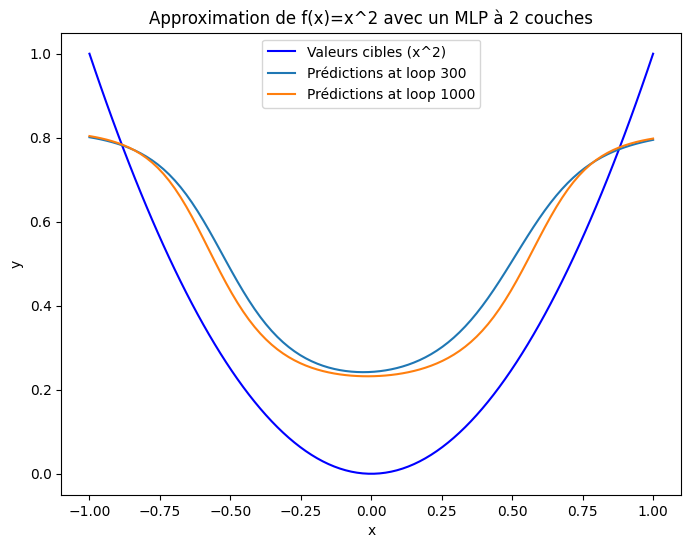

In [47]:
# Exercise 10 (*): try to approximate the n^2 function with a 2-layer MLP.  why is it so hard?
lr = 0.01
x_values = np.linspace(-1, 1, 100)
x_inputs = [[x] for x in x_values]
y_values = [x**2 for x in x_values]
n = MLP(1, [4, 4, 1]) # 4 neurons per layers, one input, one output 
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label="Valeurs cibles (x^2)", color="blue")
for k in range(1001):
    # forward pass (compute the loss)
    ypred = [n(x) for x in x_inputs]
    output = [y.data for y in ypred]
    if k == 300 or k==1000: 
        plt.plot(x_values, output, label=f"Prédictions at loop {k}")
    loss = sum([(a-b)**2 for (a,b) in zip(ypred, y_values)]) # MSE between ypred and ground-truth
    #backward pass 
    loss.backward()
    # update
    for p in n.parameters():
        p.data -= lr * p.grad
        p.grad = 0.0
    print(k, loss.data)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Approximation de f(x)=x^2 avec un MLP à 2 couches")
plt.show()

It comes from the fact that the square function is highly non-linear. The architecture and initialization might not be ideal, and the optimization landscape could cause issues, like vanishing gradients or the tanh activation saturating for large inputs. Since tanh is bounded, it struggles when trying to approximate unbounded functions like n**2. 